In [1]:
import os
import random
import tqdm
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.models import Sequential

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

from pylab import plt, mpl
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

import seaborn as sns
import matplotlib.pyplot as plt

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

In [2]:
df = pd.read_csv('merged_df.csv',index_col='date',parse_dates=True)
df

,symbol,RET,adjclose,MIDPOINT,ADX,MINUS_DM,PLUS_DI,PPO,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,,,
2022-09-08,ACON,0.017391,18.719999,17.968000,54.420717,3.851167,31.663132,6.091101,0.78,-0.15,-0.20,-1.29,-1.02
2022-09-08,ADD,0.000000,4.400000,4.600000,16.250726,0.752525,20.628365,-3.780616,0.78,-0.15,-0.20,-1.29,-1.02
2022-09-08,ADIL,0.020000,12.750000,13.625000,37.871648,7.841558,14.649334,-4.346338,0.78,-0.15,-0.20,-1.29,-1.02
2022-09-08,ADTX,0.000000,280.000000,318.000000,27.768153,79.967990,23.341651,-5.702175,0.78,-0.15,-0.20,-1.29,-1.02
2022-09-08,ADXN,0.040404,20.600000,22.400000,14.329310,9.558765,18.661488,-8.516981,0.78,-0.15,-0.20,-1.29,-1.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,XYLO,0.000000,2.660000,2.885000,28.457419,0.540184,8.487398,-3.849636,0.54,-0.16,0.98,0.27,-0.73
2024-02-29,YCBD,-0.053597,0.671000,0.689500,18.838222,0.116766,17.743221,-5.500466,0.54,-0.16,0.98,0.27,-0.73
2024-02-29,YOSH,0.025581,4.410000,4.875000,35.207948,1.729991,21.857853,2.603119,0.54,-0.16,0.98,0.27,-0.73


In [3]:
# construct a new column with tag of train or test


# total days in dataset
Time_diff = df.index[-1] - df.index[0]
print(Time_diff.days, 'days in the dataset')
print(np.count_nonzero(df['symbol'].unique()), 'stocks in total in the datasets')

# ratio of data for test
test_ratio = 0.2

# index splitting train and test data
test_index = df.index[0] + (Time_diff*(1-test_ratio))

# create a new column of test flag
df['test_flag'] = False                                  #all false for training
df.loc[ test_index : df.index[-1], 'test_flag' ] = True  #some data for testing based on test_ratio

539 days in the dataset
297 stocks in total in the datasets


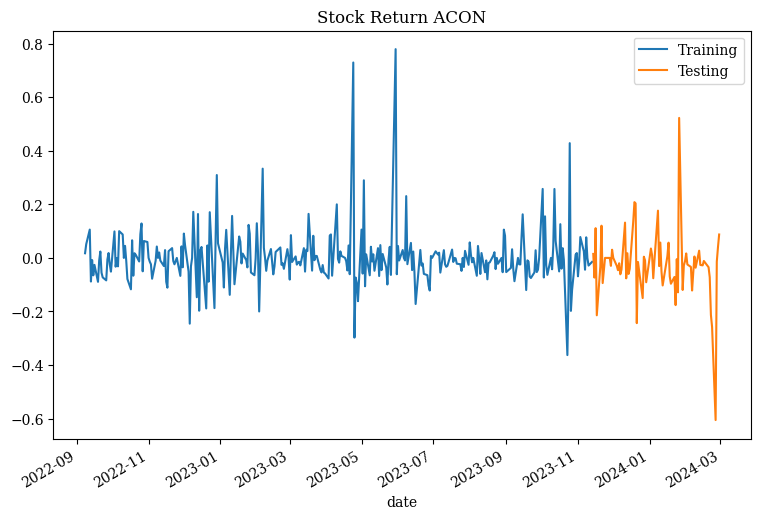

In [4]:
### PLOT SERIES FOR selected stock ###

def plot_stock(stockID):
    
    plt.figure(figsize=(9,6))
    
    df[(df['symbol']==stockID)&(df['test_flag']==False)]['RET'].plot()
    df[(df['symbol']==stockID)&(df['test_flag']==True)]['RET'].plot()
    
    plt.title('Stock Return'+' '+str(stockID))
    plt.legend(['Training','Testing'])
    plt.show()

plot_stock('ACON')

In [5]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###

# the length of each training sample (how many time steps in each sample)
# we read features in previous 4 time steps to forecast return in next time step
sequence_length = 4

def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# zip takes an iterable (list, tuple, set, or dictionary), generates a list of tuples that contain elements from each iterable
# construct LSTM input features
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


# construct LSTM output
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [6]:
### CREATE TRAIN/TEST PRICE DATA ###

col = df.columns.drop(['symbol','Mkt-RF','SMB','HML','RMW','CMA'])

X_train, X_test = [], []
y_train, y_test = [], []

for (stock,is_test), _df in df.groupby(['symbol', 'test_flag']):
    
    for seq in gen_sequence(_df, sequence_length, col):        
        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)
                
    for seq in gen_labels(_df, sequence_length, ['RET']):        
        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print('shape of the intput X and output y\ninput training data dimension: ')
print(X_train.shape)
print('\noutput training data dimension: ')
print(y_train.shape)

print('\ninput testing data dimension: ')
print(X_test.shape)
print('\noutput testing data dimension: ')
print(y_test.shape)

# print several examples, only print 3 out of 101 features
for i in range(3):
    print('input ', i, ': \n',X_train[i,:,0:3])
    print('==> output ', i, ': \n', y_train[i], '\n')

shape of the intput X and output y
input training data dimension: 
(81298, 4, 8)

output training data dimension: 
(81298, 1)

input testing data dimension: 
(20209, 4, 8)

output testing data dimension: 
(20209, 1)
input  0 : 
 [[0.0173912881227429 18.719999313354492 17.967999935150146]
 [0.0512821061449741 19.68000030517578 18.31999969482422]
 [0.1056910513949036 21.760000228881836 19.11999988555908]
 [-0.0882352966957026 19.84000015258789 19.11999988555908]]
==> output  0 : 
 [-0.0081] 

input  1 : 
 [[0.0512821061449741 19.68000030517578 18.31999969482422]
 [0.1056910513949036 21.760000228881836 19.11999988555908]
 [-0.0882352966957026 19.84000015258789 19.11999988555908]
 [-0.0080645083760868 19.68000030517578 19.11999988555908]]
==> output  1 : 
 [-0.065] 

input  2 : 
 [[0.1056910513949036 21.760000228881836 19.11999988555908]
 [-0.0882352966957026 19.84000015258789 19.11999988555908]
 [-0.0080645083760868 19.68000030517578 19.11999988555908]
 [-0.0650406842884484 18.39999961853

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

print(X_train.shape)

# shape of the training data is (191220, 4, 101), it means:
# 191220 rows
# 4 rows --> 1 output (LSTM many to many application)
# 101 features in each row

(81298, 4, 8)


In [8]:
# construct model

set_seed(33)

### DEFINE LSTM AUTOENCODER ###

# input shape is (4, 101), using 4 rows to forecast one output, each row has 101 features
inputs_ae = Input(shape=(X_train.shape[1:]))

# encoding LSTM layer, receive inputs_ae from input layer
encoded_ae_2 = LSTM( int(X_train.shape[2]*1.2) , return_sequences=True, dropout=0.5)(inputs_ae, training=True)

# decoding LSTM layer, recive encoded_ae from encoding LSTM layer
decoded_ae = LSTM( int(X_train.shape[2]/2) , return_sequences=True, dropout=0.5)(encoded_ae_2, training=True)

out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse')

### TRAIN AUTOENCODER ###

# early stop
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, 
                   monitor='val_loss', mode='auto', restore_best_weights=True)

# train autoencoder with output reconstructing the input
# epochs=2 is too small, this is to save memory and time, you may try a large epochs
sequence_autoencoder.fit(X_train, X_train, validation_data=(X_train, X_train),
                         batch_size=128, epochs=10, verbose=1, callbacks=[es])


2024-05-03 18:06:15.658479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:06:15.659399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:06:15.659989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-05-03 18:06:15.890267: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-03 18:06:16.018100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:06:16.018900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:06:16.019576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

635/636 [============================>.] - ETA: 0s - loss: 0.8255

2024-05-03 18:06:19.067295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:06:19.067873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:06:19.068436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

636/636 [==============================] - 4s 4ms/step - loss: 0.8254 - val_loss: 0.8006
Epoch 2/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7864 - val_loss: 0.7766
Epoch 3/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7683 - val_loss: 0.7573
Epoch 4/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7571 - val_loss: 0.7481
Epoch 5/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7441 - val_loss: 0.7384
Epoch 6/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7348 - val_loss: 0.7327
Epoch 7/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7323 - val_loss: 0.7292
Epoch 8/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7247 - val_loss: 0.7233
Epoch 9/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7229 - val_loss: 0.7185
Epoch 10/10
636/636 [==============================] - 2s 3ms/step - loss: 0.7194 - val_loss: 0.7176


In [9]:
### ENCODE PRICE AND CONCATENATE REGRESSORS ###

# to obtain the encoded information and concatenating it with the 
# original features, along with the last imension: 
# 101 original features + 121 encoded features = 222
encoder = Model(inputs_ae, encoded_ae_2)
encoded_feature_train = encoder.predict(X_train)
encoded_feature_test = encoder.predict(X_test)

# dimension of encoded features
print('encoded features: ', encoded_feature_train.shape)

X_train_ = np.concatenate([X_train, encoded_feature_train], axis=-1)
X_test_ = np.concatenate([X_test, encoded_feature_test], axis=-1)

# original data
print('original training data shape: ', X_train.shape)
print('original testing data shape: ', X_test.shape)

# each row of X_train_ and X_test_ has 222 features
print('concatenated training data shape: ', X_train_.shape)
print('concatenated testing data shape: ', X_test_.shape)


 189/2541 [=>............................] - ETA: 1s 

2024-05-03 18:06:37.780601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:06:37.781894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:06:37.782753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

632/632 [==============================] - 0s 448us/step
encoded features:  (81298, 4, 9)
original training data shape:  (81298, 4, 8)
original testing data shape:  (20209, 4, 8)
concatenated training data shape:  (81298, 4, 17)
concatenated testing data shape:  (20209, 4, 17)


In [10]:
set_seed(33)

### DEFINE STANDARD LSTM FORECASTER ###

inputs = Input(shape=(X_train_.shape[1:]))
lstm = LSTM(128, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

### FIT FORECASTER ###
# epochs=2 is too small, you may try 100 instead
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, 
                   monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train_, y_train, validation_data=(X_train_, y_train), 
          epochs=20, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/20


2024-05-03 18:06:40.616725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:06:40.617436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:06:40.618290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

633/636 [============================>.] - ETA: 0s - loss: 0.0971

2024-05-03 18:06:47.976269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:06:47.976990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:06:47.977582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

636/636 [==============================] - 10s 13ms/step - loss: 0.0968 - val_loss: 0.0966
Epoch 2/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0967 - val_loss: 0.0965
Epoch 3/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0967 - val_loss: 0.0966
Epoch 4/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0966 - val_loss: 0.0966
Epoch 5/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0964 - val_loss: 0.0965
Epoch 6/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0966 - val_loss: 0.0961
Epoch 7/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0967 - val_loss: 0.0967
Epoch 7: early stopping


In [11]:
### COMPUTE STOCHASTIC DROPOUT ###

# scores_MSE = []
# scores_RSquare = []
# for i in tqdm.tqdm(range(0,50)):
#     scores_MSE.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))
#     scores_RSquare.append(r2_score(y_test, model.predict(X_test).ravel()))


scores = []
for i in tqdm.tqdm(range(0,20)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test_).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/20 [00:00<?, ?it/s]2024-05-03 18:07:33.069756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:07:33.070359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:07:33.071292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore th

632/632 [==============================] - 1s 1ms/step


  5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

632/632 [==============================] - 1s 2ms/step


 10%|█         | 2/20 [00:02<00:22,  1.23s/it]

632/632 [==============================] - 1s 1ms/step


 15%|█▌        | 3/20 [00:03<00:18,  1.12s/it]

632/632 [==============================] - 1s 1ms/step


 20%|██        | 4/20 [00:04<00:16,  1.05s/it]

632/632 [==============================] - 1s 1ms/step


 25%|██▌       | 5/20 [00:05<00:15,  1.01s/it]

632/632 [==============================] - 1s 1ms/step


 30%|███       | 6/20 [00:06<00:14,  1.00s/it]

632/632 [==============================] - 1s 1ms/step


 35%|███▌      | 7/20 [00:07<00:13,  1.01s/it]

632/632 [==============================] - 1s 1ms/step


 40%|████      | 8/20 [00:08<00:12,  1.01s/it]

632/632 [==============================] - 1s 1ms/step


 45%|████▌     | 9/20 [00:09<00:11,  1.01s/it]

632/632 [==============================] - 1s 1ms/step


 50%|█████     | 10/20 [00:10<00:09,  1.01it/s]

632/632 [==============================] - 1s 1ms/step


 55%|█████▌    | 11/20 [00:11<00:08,  1.02it/s]

632/632 [==============================] - 1s 2ms/step


 60%|██████    | 12/20 [00:12<00:08,  1.01s/it]

632/632 [==============================] - 1s 1ms/step


 65%|██████▌   | 13/20 [00:13<00:07,  1.00s/it]

632/632 [==============================] - 1s 1ms/step


 70%|███████   | 14/20 [00:14<00:06,  1.01s/it]

632/632 [==============================] - 1s 1ms/step


 75%|███████▌  | 15/20 [00:15<00:05,  1.02s/it]

632/632 [==============================] - 1s 1ms/step


 80%|████████  | 16/20 [00:16<00:04,  1.01s/it]

632/632 [==============================] - 1s 2ms/step


 85%|████████▌ | 17/20 [00:17<00:03,  1.02s/it]

632/632 [==============================] - 1s 1ms/step


 90%|█████████ | 18/20 [00:18<00:02,  1.03s/it]

632/632 [==============================] - 1s 1ms/step


 95%|█████████▌| 19/20 [00:19<00:01,  1.02s/it]

632/632 [==============================] - 1s 2ms/step


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

0.054390008934917876 3.359559474036609e-05


In [12]:
# results = {'LSTM':None, 'Autoencoder+LSTM':None}
# results['Autoencoder+LSTM'] = {'mean_MSE':np.mean(scores_MSE), 'std_MSE':np.std(scores_MSE)}
# results['Autoencoder+LSTM'] = {'mean_R2':np.mean(scores_RSquare), 'std_R2':np.std(scores_RSquare)}
# print(results)

results = {'LSTM':None, 'Autoencoder+LSTM':None}
results['Autoencoder+LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}
print(results)

{'LSTM': None, 'Autoencoder+LSTM': {'mean': 0.054390008934917876, 'std': 3.359559474036609e-05}}


In [13]:
### Using Simple LSTM model

set_seed(33)

### DEFINE FORECASTER ###

inputs = Input(shape=(X_train.shape[1:]))
lstm = LSTM(128, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

### FIT FORECASTER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_train, y_train), 
          epochs=20, batch_size=128, verbose=1, callbacks=[es])

2024-05-03 18:07:53.634952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:07:53.635669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:07:53.636157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-03 18:07:53.734370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:07:53.734876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:07:53.735598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

629/636 [============================>.] - ETA: 0s - loss: 0.0976

2024-05-03 18:08:00.300916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:08:00.301868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:08:00.302639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

636/636 [==============================] - 8s 11ms/step - loss: 0.0968 - val_loss: 0.0966
Epoch 2/20
636/636 [==============================] - 7s 11ms/step - loss: 0.0967 - val_loss: 0.0966
Epoch 3/20
636/636 [==============================] - 6s 10ms/step - loss: 0.0967 - val_loss: 0.0966
Epoch 4/20
636/636 [==============================] - 6s 10ms/step - loss: 0.0967 - val_loss: 0.0966
Epoch 5/20
636/636 [==============================] - 6s 10ms/step - loss: 0.0966 - val_loss: 0.0966
Epoch 6/20
636/636 [==============================] - 6s 10ms/step - loss: 0.0966 - val_loss: 0.0964
Epoch 7/20
636/636 [==============================] - 6s 10ms/step - loss: 0.0966 - val_loss: 0.0964
Epoch 7: early stopping


In [14]:
### COMPUTE STOCHASTIC DROPOUT ###

# scores_MSE = []
# scores_RSquare = []
# for i in tqdm.tqdm(range(0,50)):
#     scores_MSE.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))
#     scores_RSquare.append(r2_score(y_test, model.predict(X_test).ravel()))


scores = []
for i in tqdm.tqdm(range(0,20)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/20 [00:00<?, ?it/s]2024-05-03 18:08:40.887672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 18:08:40.888432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 18:08:40.889108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore th

632/632 [==============================] - 1s 1ms/step


  5%|▌         | 1/20 [00:01<00:24,  1.31s/it]

632/632 [==============================] - 1s 1ms/step


 10%|█         | 2/20 [00:02<00:19,  1.06s/it]

632/632 [==============================] - 1s 1ms/step


 15%|█▌        | 3/20 [00:03<00:16,  1.03it/s]

632/632 [==============================] - 1s 1ms/step


 20%|██        | 4/20 [00:03<00:14,  1.08it/s]

632/632 [==============================] - 1s 1ms/step


 25%|██▌       | 5/20 [00:04<00:13,  1.10it/s]

632/632 [==============================] - 1s 1ms/step


 30%|███       | 6/20 [00:05<00:12,  1.08it/s]

632/632 [==============================] - 1s 1ms/step


 35%|███▌      | 7/20 [00:06<00:11,  1.11it/s]

632/632 [==============================] - 1s 2ms/step


 40%|████      | 8/20 [00:07<00:11,  1.02it/s]

632/632 [==============================] - 1s 1ms/step


 45%|████▌     | 9/20 [00:08<00:10,  1.02it/s]

632/632 [==============================] - 1s 1ms/step


 50%|█████     | 10/20 [00:09<00:09,  1.01it/s]

632/632 [==============================] - 1s 1ms/step


 55%|█████▌    | 11/20 [00:10<00:08,  1.01it/s]

632/632 [==============================] - 1s 1ms/step


 60%|██████    | 12/20 [00:11<00:07,  1.01it/s]

632/632 [==============================] - 1s 1ms/step


 65%|██████▌   | 13/20 [00:12<00:06,  1.03it/s]

632/632 [==============================] - 1s 1ms/step


 70%|███████   | 14/20 [00:13<00:05,  1.04it/s]

632/632 [==============================] - 1s 1ms/step


 75%|███████▌  | 15/20 [00:14<00:04,  1.05it/s]

632/632 [==============================] - 1s 1ms/step


 80%|████████  | 16/20 [00:15<00:03,  1.06it/s]

632/632 [==============================] - 1s 1ms/step


 85%|████████▌ | 17/20 [00:16<00:02,  1.06it/s]

632/632 [==============================] - 1s 1ms/step


 90%|█████████ | 18/20 [00:17<00:01,  1.07it/s]

632/632 [==============================] - 1s 1ms/step


 95%|█████████▌| 19/20 [00:18<00:00,  1.05it/s]

632/632 [==============================] - 1s 1ms/step


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

0.05396478230784718 3.117323627926029e-05


In [15]:
# results['LSTM'] = {'mean_MSE':np.mean(scores_MSE), 'std_MSE':np.std(scores_MSE)}
# results['LSTM'] = {'mean_R2':np.mean(scores_RSquare), 'std_R2':np.std(scores_RSquare)}
results['LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

for key, value in results.items():
    print(key, ': ', value, '\n')




LSTM :  {'mean': 0.05396478230784718, 'std': 3.117323627926029e-05} 

Autoencoder+LSTM :  {'mean': 0.054390008934917876, 'std': 3.359559474036609e-05} 

